*__Disclaimer 1__*: due to the DSBA server being slow as most of the groups were working on it this project was done on a PC with CUDA v10 and a Nvidia GTX 1060 32gb 4 core. Due to the memory restrcitions some parameter setups were not explorable as explained throughout the notebook. This restriction mostly applies to the batch size, image size and number of unfrozen layers.*

*__Disclaimer 2__: the project was initially meant to be an object detection for logos to use as a marketing strategy solution. However we noticed that the dataset size, computational power, time and our own knowledge were too limited for such task and using a premade research model such as YOLO or Faster-RCNN from the tensorflow zoo did not allow for much freedom in terms of parameterisation.*

# Image Classification through Fine Tuning to Match Dish and Recipe 

# Package Imports 

In [27]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import functools
import shutil
import time
import pickle 
import cv2

from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from sklearn.neighbors import KNeighborsClassifier
from keras.callbacks import EarlyStopping
from keras import regularizers

tf.enable_eager_execution()

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data Preprocessing

We used the __Food101__ dataset found online. <br> It includes 101 different foods with __1000__ photos for each food item. <br> We selected __11 classes__ to train our model because of GPU limitations and the need for a quicker model to be able to tune parameters and test different configurations.

## Defining Paths

In [2]:
# Define path to text files
classes_path = './input_data/meta/classes.txt'
images_dir = './input_data/images'

# define necessary paths
eval_dir = './input_data/eval'
test_dir = './output_data/test'

## Image Example (here sushi)

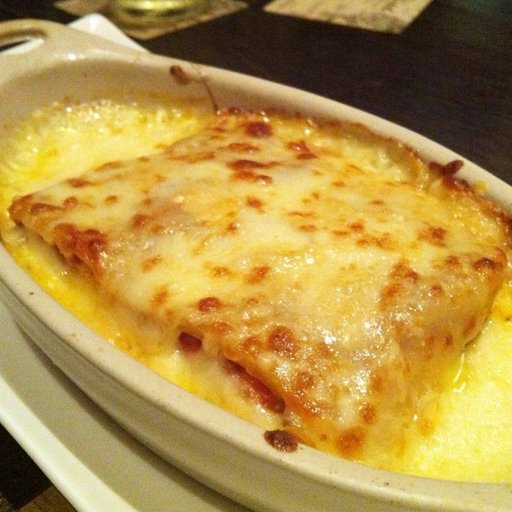

In [7]:
# define path to apple pie images folder
lasagna_dir = './input_data/images/lasagna'

# retrieve list of image names
lasagnas = os.listdir(lasagna_dir)

# open first 3 images
for image_path in lasagnas[:1]:
    display.display(Image.open(str(lasagna_dir + '/' + image_path)))

## Retrieve Classes from Folder Names

In [8]:
# retrieve all classes
class_names = os.listdir(images_dir)

print('Classes used are:' + str(class_names))

Classes used are:['breakfast_burrito', 'caesar_salad', 'cannoli', 'chicken_wings', 'french_fries', 'hamburger', 'lasagna', 'pizza', 'ravioli', 'sushi', 'waffles']


## Split Train, Evaluation and Test Sets

The helper function utilises OS package to transfer some images to a test and eval folder to then run ```flow_from_directory``` function. 

The chosen weights are standard being __80% training, 10% evaluation and 10% testing__. <br>
This represents a 8800, 1100, 1100 repartition of samples.

### Define helper function

In [9]:
def split_images(input_dir, eval_dir, test_dir, set_weights):
    """
  Function to split train and eval sets randomly given the eval_set ratio. This function will move prictures to the appropriate
  directory and create the necessary file.

  Parameters:
  - input_dir: string
      String relative path to the images directory
  - eval_dir: string
      String relative path to the evalution directory
  - eval_ratio: float (default = 0.2)
      Ratio of the original image set to use for evaluation. Must be between 0 and 1 included. 
    """

    # list folders in the images directory
    classes = os.listdir(input_dir)

    # loop over folders == classes
    for cls in classes:
        if cls != '.DS_Store':  # google collab ads invisible folder to remove
            # create temp directory path to each class for each of the sets
            temp_dir_input = input_dir + '/{}'.format(cls)
            temp_dir_eval = eval_dir + '/{}'.format(cls)
            temp_dir_test = test_dir + '/{}'.format(cls)

            # create a class folder in the eval set and test
            os.mkdir(temp_dir_eval)
            os.mkdir(temp_dir_test)

            # list images in the class of the current loop
            images = os.listdir(temp_dir_input)

            # shuffle image list to random assign
            random.shuffle(images)

            # split according to ratio
            train_ratio = round(set_weights[0] / 10 * len(images))
            eval_ratio = train_ratio + round(set_weights[1] / 10 * len(images))

            eval_imgs = images[train_ratio:eval_ratio]
            test_imgs = images[eval_ratio:]

            # loop over images
            c = 0
            for l in [eval_imgs, test_imgs]:
                for img in l:
                    if c == 0:
                        shutil.move(temp_dir_input + '/' + img, temp_dir_eval + '/')
                    else:
                        shutil.move(temp_dir_input + '/' + img, temp_dir_test + '/')
                c += 1

    return print('Sets prepared.')

### Spliting data

In [10]:
# here 80% train etc.
weights = [8, 1, 1]

# commented out to avoid splitting everytime the kernel is rerun
# split_images(images_dir, eval_dir, test_dir,  weights)

# Data Augmentation

In this part we will perform data augmentation in order to __increase our training samples__ and __avoid overfitting__ *too* much.

### Define Generator Input Parameters

Batch size was increase to 100 due to untrusted labels (see picture in presentation). <br>
<br>
*N.B. a __bigger__ batchsize and __bigger__ images would have been ideal to test with a consequently a higher __learning rate__ to intake more complexity which would be required with more classes, sadly my PCs GPU memory (32gb) was not sufficient enough for multiple runs for parameter tuning. <br>
With more time and better computational specs I believe the project could achieve better results.* 

In [11]:
IMG_SIZE = 160
BATCH_SIZE = 100

### Create Generators for Train and Evaluation Sets

As mentioned previously, data augmentation was __necessary__ for the project due to the small number of examples per class. <br>
Consequently, a fair amount a augmentation parameters were fed into our generator.

In [12]:
# Define augmentations to all to counter overfitting with low data
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

# define eval set just rescaled
test_datagen = ImageDataGenerator(rescale=1./255)

# retrieve images
train_generator = train_datagen.flow_from_directory(
        # image directory
        images_dir,
        # All images will be resized to 160x650
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True,
        classes=class_names
        )

validation_generator = test_datagen.flow_from_directory(
        eval_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True,
        classes=class_names
        )

Found 8800 images belonging to 11 classes.
Found 1100 images belonging to 11 classes.


## Show some images with class_names

Creation and use of a simple custom function to display some of the picture (some being augmentations).

### Define helper function

In [13]:
def show_batch(image_batch, label_batch, num_img=4):
  """
  Function that takes an image batch and outputs a photo of x images and their class names.

  # arguments
  - image_batch: batch from generator
  - label_batch: batch from generator
  - num_img: int (default=4)
      Integer value of the number of photos to display.

  # Return
  Displays pictures with respective class names.
  """ 
  plt.figure(figsize=(10,10))
  for n in range(4):
      ax = plt.subplot(2,2,n+1)
      plt.imshow(image_batch[n])
      # find index if 1 == class
      temp_index = np.where(label_batch[n] == 1)[0][0]
      # match it to class_names list
      plt.title(class_names[temp_index])
      plt.axis('off')

### Show Batch Images

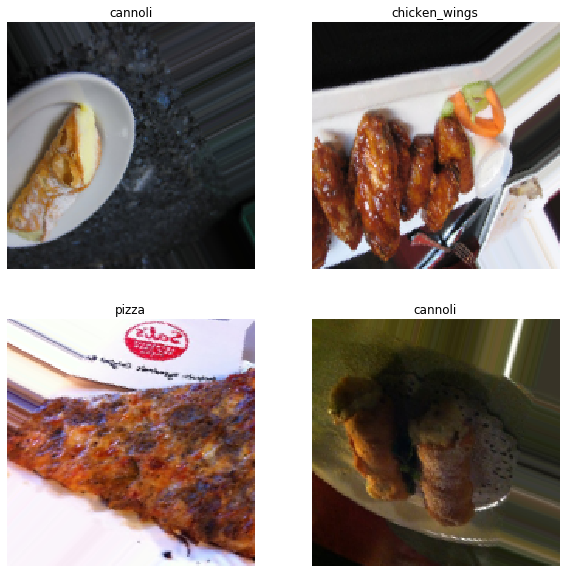

In [14]:
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

# Model Creation

## Hyper-Parameters Tuning

This represented most of the coding and computational issues faced for the training. <br>
__Ideally__, one would want to use ```talos```and ```waggle``` and make use of the ```Scan()```function to do hyper-parameter tuning on keras neural networks. __But__, this package does not yet work with *generators* and feeding the entire training set at once caused memory errors. <br>
__Consequently__, a custom python loop was created to randomly chose some configurations on what we considered the most important parameters, to have a better idea on what to use. This config were tested and model final metrics and configuration stored. In an ideal scenario, *much __more__* parameter options would be used but time and computational restrictions did not able us to do that.<br>
<br>
In the following cell you can see the some of the different parameters tested in the p dictionary. <br>
An ```EarlyStopping``` callback was added to avoid unecessary training. Only final history results are saved as they represent the average over epochs.<br> <br>

*N.B.: <br>
1) please look at comments in p definition for justification of chosen parameters. <br>
2) this is only an example of one of the loops run. After each run we would look at results and adjust parameter ranges to eventually try to pinpoint a better local minima for our model optimisation.*

*Project made in pycharm, this function was not run on this notebook which is why there are not visible outputs*

In [ ]:
# set the parameter space boundary
p = {'dropout': [0.0, 0.2, 0.4], # dropout regularisation used to avoid overfitting by changing network node config mapping
     'learning_rate': [0.01, 0.001], # 2 tested as freezing more a less layers == more trainable params 
     'epochs': [10, 20],
     'freeze_perc': [0.8, 0.9, 1],
     'l1': [0, 0.01, 0.001]}

# add a progress bar with tqdm
for test in tqdm(range(2, 5)):
    # pick random config
    params = dict()
    params['dropout'] = random.choice(p['dropout'])
    params['learning_rate'] = random.choice(p['learning_rate'])
    params['epochs'] = random.choice(p['epochs'])
    params['freeze_perc'] = random.choice(p['freeze_perc'])
    params['l1'] = random.choice(p['l1'])

    # Create the base model from the pre-trained model MobileNet V2
    base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                                   include_top=False,
                                                   weights='imagenet')
    
    # freeze X% layers
    num_layer_freezed = round(params['freeze_perc'] * len(base_model.layers))
    for layer in base_model.layers[:num_layer_freezed]:
        layer.trainable = False
    for layer in base_model.layers[num_layer_freezed:]:
        layer.trainable = True

    classifier_gp = tf.keras.layers.Flatten()  # changed to flatten to avoid averaging and get more specific class info
    # classifier_d1 = tf.keras.layers.Dense(1024, activation='relu')
    # classifier_do1 = tf.keras.layers.Dropout(0.2)
    classifier_d2 = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l1(
        params['l1']))  # add regularisation to avoid overfitting
    # removed a layer to decrease num of parameters to train --> small dataset bad ratio
    classifier_do2 = tf.keras.layers.Dropout(params['dropout'])
    classifier_d3 = tf.keras.layers.Dense(512, activation='relu', name='last_classifier')

    # output prediction with num of class
    prediction_layer = tf.keras.layers.Dense(11, activation='softmax')  # final layer with softmax activation

    # group all layers
    model_v1 = tf.keras.Sequential([
        base_model,
        classifier_gp,
        # classifier_d1,
        # classifier_do1,
        classifier_d2,
        classifier_do2,
        classifier_d3,
        prediction_layer
    ])

    # compile model with categorical because multi class
    base_learning_rate = params['learning_rate']
    early_stopping = EarlyStopping(monitor='val_loss', patience=2)  # added early stop to avoid unnecessary configs
    model_v1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

    # train model_v1
    history = model_v1.fit_generator(train_generator,
                                     steps_per_epoch=(8800 // BATCH_SIZE),
                                     epochs=params['epochs'],
                                     validation_data=validation_generator,
                                     validation_steps=40,
                                     verbose=2)

    f = open('output_data/models/checkpoints/tests_done_hyper_param.txt', "a+")

    temp_str = os.linesep + 'v{}'.format(test) + str(params) + os.linesep + ' acc: {}'.format(
        history.history['acc'][-1]) + ' loss: {}'.format(
        history.history['loss'][-1]) + ' val acc: {}'.format(
        history.history['val_acc'][-1]) + ' val loss: {}'.format(history.history['val_loss'][-1]) + os.linesep
    f.write(temp_str)
    f.close()

    print('Done: /n ' + str(params) + os.linesep + ' acc: {}'.format(history.history['acc'][-1]) + ' loss: {}'.format(
        history.history['loss'][-1]) + ' val acc: {}'.format(
        history.history['val_acc'][-1]) + ' val loss: {}'.format(history.history['val_loss'][-1]))
    # let's save the output
    model_v1.save(os.path.join('./output_data/models/', '{}.h5'.format('v' + str(test))))
    
    # reset session to liberate cache
    reset_keras(model_v1)


### Helper Function to Reset GPU cache between runs 

In [ ]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import gc


# Reset Keras Session
def reset_keras(model):
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model  # this is from global space - change this as you need
    except:
        pass

    print(gc.collect())  # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

## Base Model

*Following configuration is the final configuration settled on.*

In [20]:
# image batch shape
print('Image Batch Shape: ' + str(image_batch.shape))

# define image shape for input
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

Image Batch Shape: (100, 160, 160, 3)


__Prebuilt Base Architecture__: MobileNet_v2 used because our business idea is to run this model on an app. A model runnable on phone is required. <br>
__Pretrained data__: Imagenet due to the similarity of the data to ours. *i.e. had food item labeled* 

The final __learning rate__ is very low due to the similarity between our labels and the imagenet labels and due to the amount of unfrozen layers (cf. hereafter). However, in application much more dishes and recipe variants would be added to the app leading to the necessity of additional learning.

In [15]:
learning_rate = 0.001

The final regularisation terms chosen were __0__ for the __dropout__ which is mostly due to the small batch size used here because of GPU limitations. <br> <br>
An __l1__ loss regularisation was still maintain to counter overfitting observe by val_acc decreasing during training. Reducing learning rate or the number of epochs even more seemed too much. __l1__ was chosen over the prefered __l2__ regularisation due to its potential to compress the model which in our application is better as it would be run on mobile apps. 

In [16]:
l1 = 0.01

dropout = 0

__Epochs__ divided by 2 to avoid observed midway overfitting despite augmentation and regularisation. 

In [17]:
epochs = 10

GPU memory restrictions stopped us from unfreezing the entire model so we settled on the next best. __20%__ of the __layers__ are __frozen__ to fine tune most of the model. Additional classes/recipes would most likely required fine tuning the entire model and increasing the learning rate. However, our little amount of classes must have counter this restriction as first layers only capture very common patterns.

In [18]:
freeze_percent = 0.2 # 20% frozen layers

In [24]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


# freeze some layers for fine-tuning
# as our recognition is done only on food and we assume user uses it on food we can freeze most of top layers
# as we don't have much data we have to freeze more to avoiding overfitting
index_freeze = round(0.2 * len(base_model.layers))
for layer in base_model.layers[:index_freeze]:
    layer.trainable=False
for layer in base_model.layers[index_freeze:]:
    layer.trainable=True

print(str(index_freeze) + ' out of {} layers frozen.'.format(len(base_model.layers)))

# base model architecture
base_model.summary()

31 out of 155 layers frozen.
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________

## Classification Model

Steps: <br>
- removed some layers because of overfitting (too much complexity)
- added regularisers l1 (to go to 0 because of not many classes) and dropout both to reduce overfitting
- changed globalpooling to flatten classifier structure to avoid average as 2d pooling does. Allow for the model de differenciate better between similar types of food (i.e. different sort of puddings, etc.)
- last dense layer with softmax activation and number of classes is a given in multi-class classification.

In [29]:
# add dense layers to capture more comlex details
# add dropout in final layers to drop some of the guesses and enhance learning process
# classifier_gp = tf.keras.layers.GlobalAveragePooling2D()
classifier_gp = tf.keras.layers.Flatten()  # changed to flatten to avoid averaging and get more specific class info
# classifier_d1 = tf.keras.layers.Dense(1024, activation='relu')
# classifier_do1 = tf.keras.layers.Dropout(0.2)
classifier_d2 = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l1(l1))  
# removed a layer to decrease num of parameters to train --> small dataset bad ratio
classifier_do2 = tf.keras.layers.Dropout(dropout)
classifier_d3 = tf.keras.layers.Dense(512, activation='relu', name='last_classifier')

# output prediction with num of class
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')  # final layer with softmax activation

### Prediction layer

In [30]:
# output prediction with num of class
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax') #final layer with softmax activation

## Final Model V1: Keras Dense prediction

In [32]:
# group all layers
model_v1 = tf.keras.Sequential([
  base_model,
  classifier_gp,
  # classifier_d1, # remove complexity too much overfitting
  # classifier_do1,
  classifier_d2,
  classifier_do2,
  classifier_d3,
  prediction_layer
])

__Adam__ optimiser used for speed and because of its performancee at lower learning rates.

In [33]:
# compile model with categorical because multi class
model_v1.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# display summary of model
model_v1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
last_classifier (Dense)      (None, 512)               5

In [34]:
# display number of variables being trained
len(model_v1.trainable_variables)

132

## Model V2: KNN prediction

Second model tested is similar to the first model but a last ```Dense```layer was removed and replaced by a ```scikit-learn``` kNN to see how differently it performs. <br>
Sadly, proper tuning was not possible due to lack of time.
<br> <br>
*__Metric Chosen__: hamming to allow for overlap of similar classes (i.e. again multiple types of puddings, etc.)*

### Helper functions

Keras function which allows us to ask the keras model to output the __k__ best values at the second to last layer to then feed these in the kNN.

In [35]:
def top_k_ouputs(batch_features):
  """
  Keras function to get top k most likely category labels from model output.

  - batch_features: 
      Tensor output of the model v2 = feature extractor and classification layers
  """
  return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=10)

Custom function to create sets for kNN based on previous model outputs (again dense 512 layer NOT dense #classes layer) <br>
__Hamming__ distance metric used to allow for overlap which would mostly be a scenario with more classes. <br>
__N.B.__ Model only fitted not optimised, optimisation would be necessary to compare performances.

In [36]:
def knn_train(train_dir, model, class_list):
  # get class folders
  temp_folders = os.listdir(train_dir)

  # create a y_train and y_true list to store values
  y_preds = np.array([], dtype=np.float64).reshape(0,512)
  y_trues = np.array([], dtype=np.int64)

  # initialise knn model to batch size
  knn_model = KNeighborsClassifier(n_neighbors=100, ) # number of batch_size
  
  # loop over classes with progress bar
  for cls in tqdm(temp_folders): 
    if cls != '.ipynb_checkpoints': # google collab ads invisible folder to remove
    # create temp directory path to each class
      temp_dir_train = train_dir + '/{}'.format(cls)

      # list images in the class of the current loop
      images = os.listdir(temp_dir_train) 

      # loop over images   
      for i in images:
        img_og = np.array(Image.open(temp_dir_train + '/{}'.format(i)))
        img = cv2.resize(img_og,(160,160))
        img = np.reshape(img,[1,160,160,3]).astype(float)

        # store top k accuracies
        y_preds = np.vstack([y_preds, model.predict(img)])
        y_trues = np.append(y_trues, class_list.index(cls))


  # once train set is complete create and fit classifier
  knn_model.fit(y_preds, y_trues)

  print('kNN finished training.')

  return knn_model

### Build Model v2

In [37]:
# no need to train as weights from all but prediction layers will be loaded to avoid multiple training
# same as model_v1 but without last dense activation layer
model_v2 = tf.keras.Sequential([
  base_model,
  classifier_gp, 
  # classifier_d1,
  # classifier_do1,
  classifier_d2,
  classifier_do2,
  classifier_d3,
  ])

# compiling done after getting weights from train on v1

# Training of the Model

## Defining Parameters

*Final parameters chosen after hyper-parameter optimisation.*

In [38]:
steps_per_epoch = 8800 // BATCH_SIZE # this is to go over all data each epoch batch * num_steps == training samples
validation_steps = 20

## Training

In [39]:
# train model_v1
# history = model_v1.fit_generator(
#       train_generator,
#       steps_per_epoch=steps_per_epoch,
#       epochs=epochs,
#       validation_data=validation_generator,
#       validation_steps=validation_steps,
#       verbose=2)

## Save Trained Models

### Helper Function

*Function stolen from stackoverflow to retrieve weights of first model up to last layers (excluded) to avoid training twice.*

In [40]:
# function to retrieve trained weights and bias to put in new model
def copyModel2Model(model_source,model_target,certain_layer=""):        
    for l_tg,l_sr in zip(model_target.layers, model_source.layers):
        wk0=l_sr.get_weights()
        l_tg.set_weights(wk0)
        if l_tg.name==certain_layer:
            break

In [47]:
# let's save the output
# model_v1.save(os.path.join('/content/drive/My Drive/food-101/', 'model_v1.h5'))

# load for second model
model_v1.load_weights('output_data/models/vALPHA.h5')

# get appropriate weight for model_v2
copyModel2Model(model_v1, model_v2, 'classifier_last') # index all but last layer == prediction layer

# compile model with categorical because multi class and set weights
model_v2.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# display number of variables being training with fine tuning semi freezing
print(len(model_v2.trainable_variables))

# save second model too
model_v2.save(os.path.join('output_data/models/', 'model_v2.h5'))

130


## Training and Evaluation Metrics Visualisation

These represent the metrics for the final configuration of the model, none of the analysed graphs during tuning are displayed in this notebook but were essential to pinpoint overfitting issues, chosen architecture and parameters.

*Cell taken from class notebooks/tensorflow official tutorials.*

In [43]:
# import saved history
history = pd.read_csv('history_final.csv')

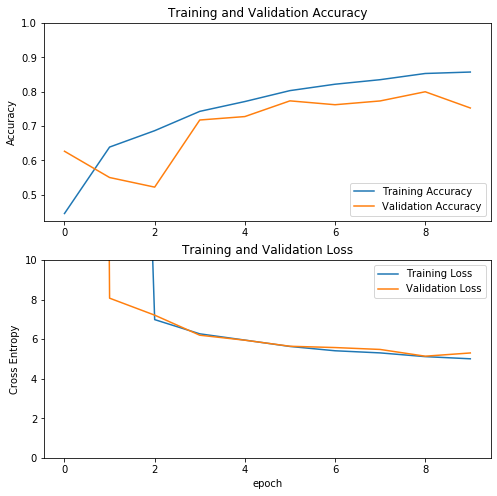

In [45]:
acc = history['acc']
val_acc = history['val_acc']

loss = history['loss']
val_loss = history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Train kNN model

In [48]:
# run training
knn_trained = knn_train(images_dir, model_v2, class_names)

# save model
pickle.dump(knn_trained, open('output_data/models/knn_model.sav', 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [10:36<00:00, 57.89s/it]


kNN finished training.


# Running Inference

## Loading Models

*N.B. : must recompile model architecture if new environment or restart*

In [49]:
# model_v1.load_weights('/content/drive/My Drive/food-101/model_v1.h5')

# load model with keras top k accuracies
model_v2 = tf.keras.models.load_model('output_data/models/model_v2.h5', custom_objects={'top_k_outputs': top_k_ouputs})
                      
kNN = pickle.load(open('output_data/models/knn_model.sav', 'rb'))

## Helper Function

In [65]:
def show_inference(file_name):
  """
  Function to open give file_name from test directory and run inference to output preds of models and picture.
  """
  img_og = np.array(Image.open('input_data/{}.jpg'.format(file_name)))
  img = cv2.resize(img_og,(160,160))
  img = np.reshape(img,[1,160,160,3]).astype(float)

  pred_v1 = model_v1.predict_classes(img)
  pred_v2 = model_v2.predict(img)
  knn_pred = kNN.predict(pred_v2)

  plt.figure(figsize=(10,10))
  plt.imshow(img_og)
  plt.title('Model V1 pred : ' + class_names[pred_v1[0]] + '\n' \
            + 'V2 + kNN pred : ' + class_names[knn_pred[0]])
  
  plt.axis('off')

  return class_names[pred_v1[0]], class_names[knn_pred[0]] 

## Test Set Evaluation

In [53]:
# get test generator 
validation_generator = test_datagen.flow_from_directory(
        eval_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True,
        classes=class_names
        )

x_test, y_test = validation_generator.__getitem__(0)

scores = model_v1.evaluate(x_test, y_test, batch_size = BATCH_SIZE, verbose=0)

Found 1100 images belonging to 11 classes.


In [57]:
print('Testing Accuracy of model V1: \n Loss: ' + str(scores[0]) + ' and Acc: ' + str(scores[1]))

Testing Accuracy of model V1: 
 Loss: 5.383642196655273 and Acc: 0.71


## Test Visualisation

Testing inference on a random picture taken from google. 

Each model seem to be wrong on one picture but it appears our second version (kNN + CNN), despite not having any work implemented into it appart from metric decision and fitting, has better prediction as mixing tomato sauce ravioli and lasagna seems acceptable.

With more time, we believe a comparison over a greater number of inference to compare accuracies would be ideal.

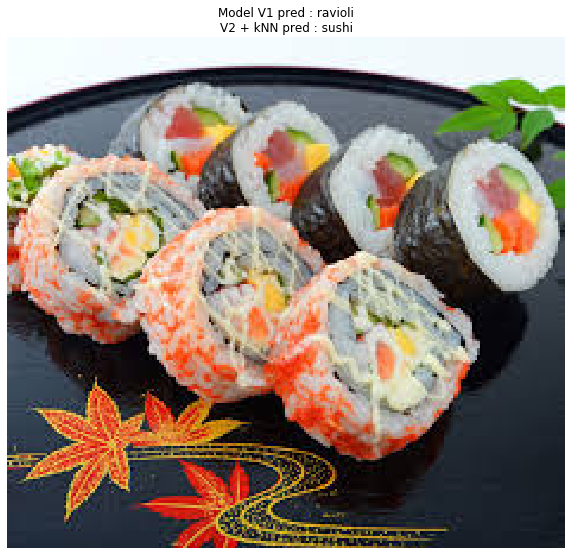

In [63]:
test_file_name = 'sushi_google'

guess_v1, guess_v2 = show_inference(test_file_name)

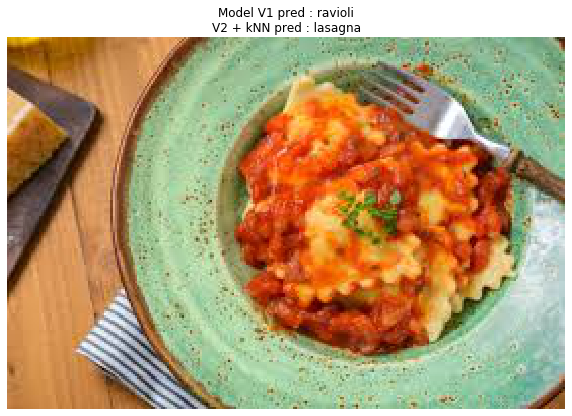

In [64]:
test_file_name2 = 'ravioli_google'

guess_v1, guess_v2 = show_inference(test_file_name2)

# Business App Additional Code

In [1]:
# Packages 
from bs4 import BeautifulSoup as bs
import requests
import webbrowser

__Theoritically:__ <br>
In use, for prediction accuracy enhancement, one would take user history to influence category weights from both models (kNN and CNN) both for individual tailor (personal interests) and overall (macro trends).

## Retrieve Video Recipe Function

Function that would in pratice be in the app to scrap the youtube videos and find the video recipes for the user. <br>
This was done very quickly and is far from optimal. As mentioned in comments, ideally one would want some NLP functions such as Regex etc. to make sure video corresponds to prediction. 
<br> <br>
*N.B. Scraping works fine but the open browser tab needs a default browser on computer and does not work wellon chrome browser so might not open video tab and return error.*

In [2]:
def find_recipe_video_for_pred(pred_label):
  # use youtube to get video recipes from scapring
  base = "https://www.youtube.com/results?search_query="

  r = requests.get(base + pred_label + 'Tutorial Recipe')

  page = r.text
  soup=bs(page,'html.parser')

  vids = soup.findAll('a',attrs={'class':'yt-uix-tile-link'})

  videolist=[]
  videotitles = []
  for v in vids:
      tmp = 'https://www.youtube.com' + v['href']
      videolist.append(tmp)
      videotitles.append(v['title'])

  # for t in videotitles: 
  #   # check if title contains recipe and class name
  #   # ideally would want to use ngrams regex of NLP to allow for all syntaxes of mistakes or even similar names 
  #   # if 'recipe' in t and pred_label in t:
  #   #   tuto_url = videolist[videotitles.index(t)]
  #   #   break


  # open video in browser
  # in truth would be in app
  return webbrowser.open(videolist[0])

In [3]:
# manual label assignment
example_pred = 'sushi'

find_recipe_video_for_pred(example_pred)

True

## Retrieve Written Recipe

Here some links were taken manually and inputted for example. Ideally an API (could not implement as they are not free) of some recipe website would be ideal to propose different sort of recipes, etc. 

In [5]:
url_dict = {'sushi': 'https://www.allrecipes.com/recipe/189477/california-roll-sushi/?internalSource=rotd&referringId=17498&referringContentType=Recipe%20Hub',
            'ravioli': 'https://www.allrecipes.com/recipe/213127/spinach-feta-and-pine-nut-ravioli-filling/?internalSource=streams&referringId=16855&referringContentType=Recipe%20Hub&clickId=st_trending_s',
            'pizza': 'https://www.allrecipes.com/recipes/1036/main-dish/pizza/chicken/?internalSource=hubcard&referringContentType=Search&clickId=cardslot%201',
            'lasagna': 'https://www.allrecipes.com/recipes/502/main-dish/pasta/lasagna/?internalSource=hubcard&referringContentType=Search&clickId=cardslot%201'
            }

def get_text_recipe(pred, url_dict):
    return webbrowser.open(url_dict[pred])

The final business application functions have not been optimized and could be much better and would have to be implement in a UI using dash or flask. Additional features would be added to enhance on customer choice such as type of recipes with one class, etc. (i.e. veg lasagna, etc.)

In [6]:
# function to open a new tab with recipe
get_text_recipe(example_pred, url_dict)

True